# Analyse second run
(this was a run using CNN based on manually labelled data)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt

import math
import json
import getpass

#import ML liberaries
import cv2


In [2]:
# Get the data from CSV file
data = pd.read_csv('data_output_lane2024-01-05 22_31_29.940136.csv')

In [3]:
# get timestamp in the right format 
data['timestamp'] = data['timestamp'].str.replace('_', ':')
data['timestamp'] = pd.to_datetime(data['timestamp'], dayfirst=True)

# Create a column that counts the time in seconds since the laast frame
data['time-sec'] = (data['timestamp'] - data['timestamp'].shift(1)).dt.total_seconds().round(2)

In [4]:
data.head(20)

,motion,timestamp,i,LMR,model_prediction,img,time-sec
0,SlowForward,2024-01-05 22:29:57.007250,0,2,1,"[[21, 28, 34, 40, 37, 27, 29, 44, 72, 79, 72, ...",NaN
1,SlowForward,2024-01-05 22:29:57.367612,1,2,1,"[[20, 28, 33, 40, 38, 25, 30, 45, 65, 77, 71, ...",0.36
2,SlowForward,2024-01-05 22:29:57.416180,2,2,1,"[[39, 48, 50, 57, 68, 67, 66, 74, 87, 92, 103,...",0.05
3,SlowForward,2024-01-05 22:29:57.551081,3,2,1,"[[35, 41, 44, 58, 67, 60, 60, 69, 94, 96, 103,...",0.13
4,SlowForward,2024-01-05 22:29:57.682187,4,2,1,"[[31, 36, 46, 55, 57, 48, 55, 65, 88, 85, 98, ...",0.13
5,SlowForward,2024-01-05 22:29:57.815694,5,2,1,"[[40, 46, 60, 61, 64, 58, 66, 77, 94, 102, 102...",0.13
6,SlowForward,2024-01-05 22:29:57.949247,6,2,1,"[[41, 45, 55, 61, 57, 53, 63, 82, 95, 95, 99, ...",0.13
7,SlowForward,2024-01-05 22:29:58.097530,7,2,1,"[[37, 49, 55, 62, 55, 53, 65, 90, 91, 96, 97, ...",0.15
8,SlowForward,2024-01-05 22:29:58.230631,8,2,1,"[[50, 57, 61, 73, 67, 68, 77, 91, 99, 107, 110...",0.13
9,SlowForward,2024-01-05 22:29:58.365453,9,2,1,"[[40, 51, 50, 49, 41, 53, 68, 84, 94, 87, 86, ...",0.13


In [5]:
len(data)

694

## 1. Visually Explore training data

In [6]:
# A function that takes the index and produce the image in that index in dataframe

def review_data (row):
    # get the image by location (as json format)
    img_as_json = data['img'][row]

    # convert the json to nested list
    img_as_list = json.loads(img_as_json)

    # convert the nested list to np.array
    img = np.array(img_as_list)

    # show the image
    plt.imshow(img, cmap='gray')
    plt.title(data['motion'][row])
    plt.show()


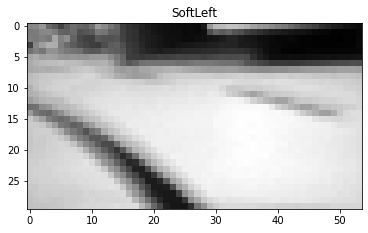

In [7]:
review_data (100)

In [8]:
    
def preview_dataset(data = data, START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # number of histograms per raws & columns
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['motion'][i]} , {data['LMR'][i]} , {data['time-sec'][i]}") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

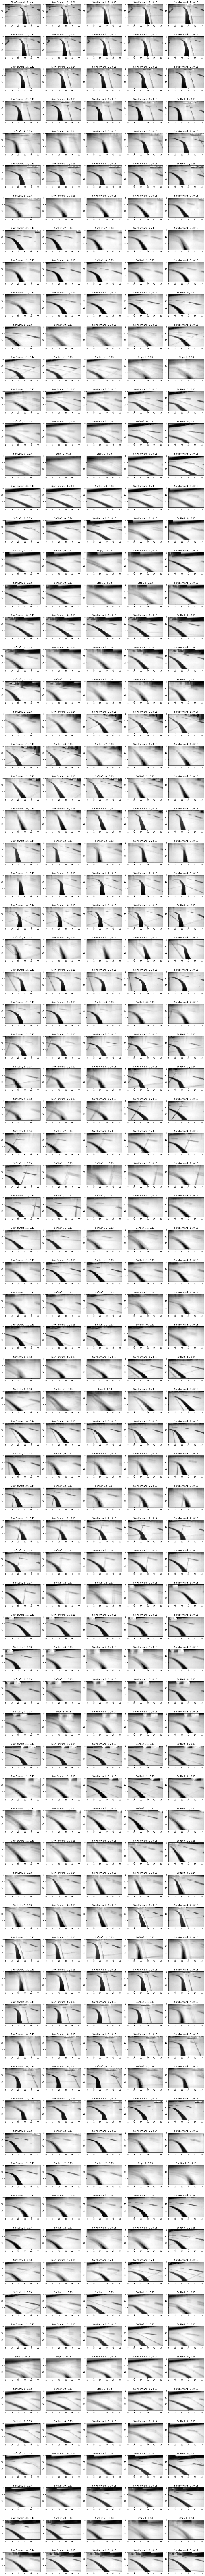

In [10]:
preview_dataset(data = data, 
                START_FRAME = 0, 
                END_FRAME = 400 )